In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
plt.style.use('fivethirtyeight')

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e16/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e16/test.csv')

print('train dataset shape is : ', train.shape)
print('test dataset shape is : ', test.shape)

train dataset shape is :  (74051, 10)
test dataset shape is :  (49368, 9)


In [3]:
train.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [4]:
test.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,74051,I,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
1,74052,I,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
2,74053,F,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
3,74054,F,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
4,74055,I,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


In [6]:
train.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,37025.000000,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,21376.826729,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,18512.500000,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,37025.000000,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,55537.500000,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,74050.000000,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


# Distribution of target variable (Age)

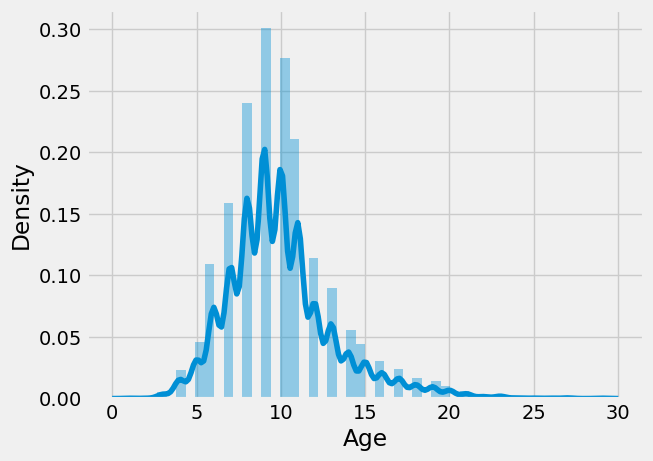

In [7]:
sns.distplot(train['Age']);

<Axes: >

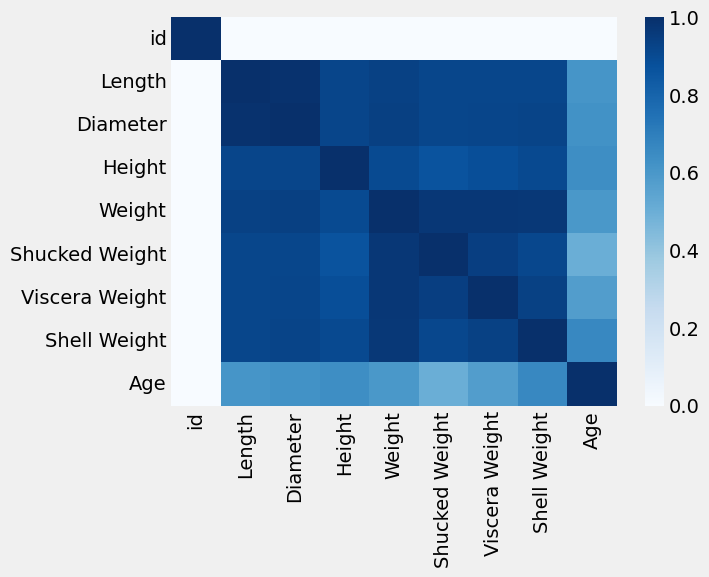

In [8]:
sns.heatmap(train.corr(),cmap='Blues')

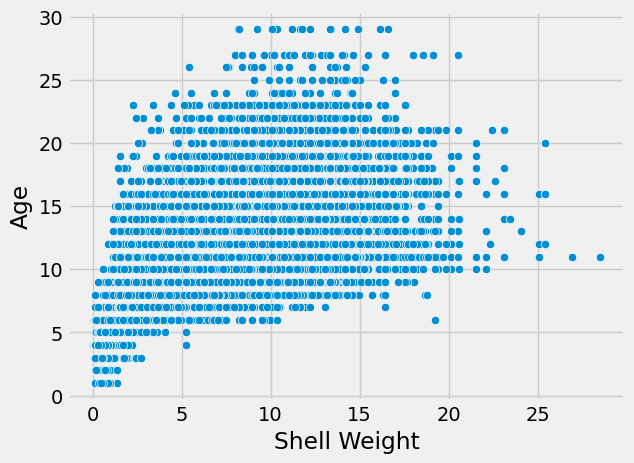

In [9]:
sns.scatterplot(data=train,x='Shell Weight',y='Age');

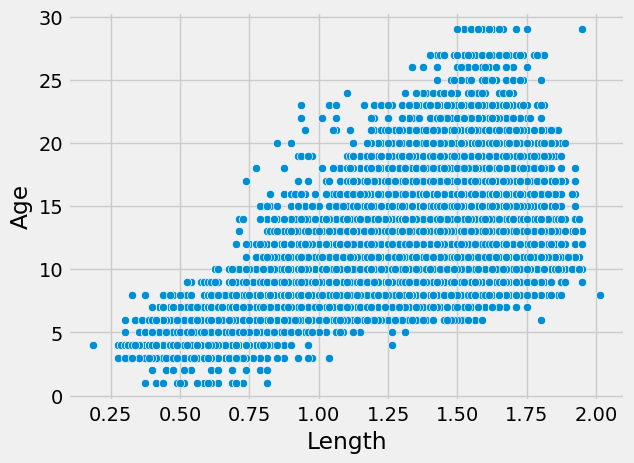

In [10]:
sns.scatterplot(data=train,x='Length',y='Age');

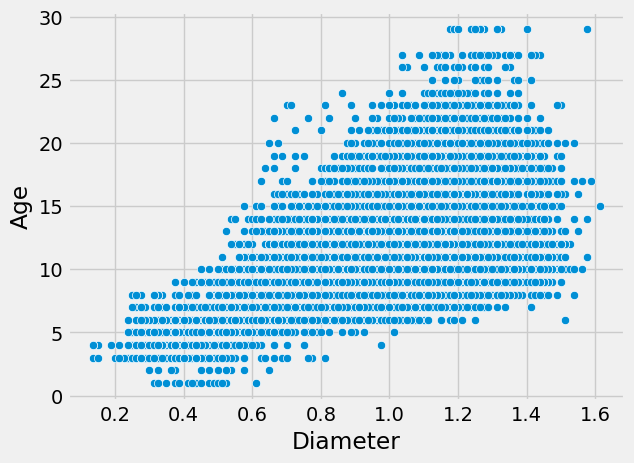

In [11]:
sns.scatterplot(data=train,x='Diameter',y='Age');

<Axes: xlabel='Sex', ylabel='count'>

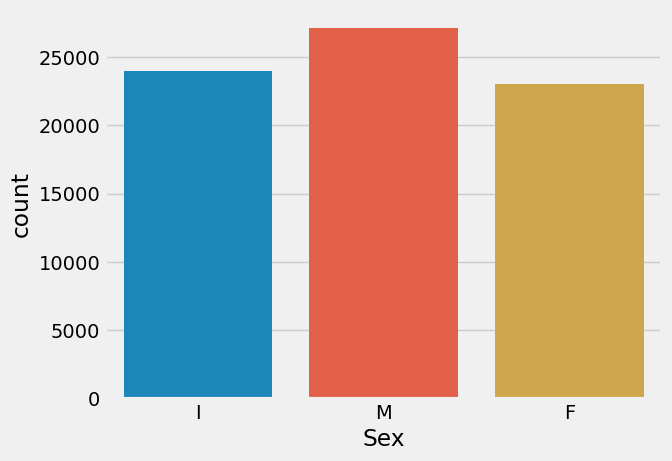

In [12]:
sns.countplot(data=train,x='Sex')

In [13]:
le = LabelEncoder()
train['Sex'] = le.fit_transform(train['Sex'])

train.drop('id',axis=1,inplace=True)

In [14]:
X = train.drop(columns = ['Age'], axis = 1)
Y = train['Age']

test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline['Sex'] = le.transform(test_baseline['Sex'])

gb_cv_scores, gb_preds = list(), list()
lgb_cv_scores, lgb_preds = list(), list()
xgb_cv_scores, xgb_preds = list(), list()
rf_cv_scores, rf_preds = list(), list()

skf = KFold(n_splits = 4, random_state = 42, shuffle = True)
    
for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
    print('---------------------------------------------------------------')
    
    # GradientBoost
    gb_md = GradientBoostingRegressor(loss = 'absolute_error',
                                      n_estimators = 1000, 
                                      max_depth = 8, 
                                      learning_rate = 0.01,
                                      min_samples_split = 10, 
                                      min_samples_leaf = 20).fit(X_train, Y_train) 
    
    gb_pred_1 = gb_md.predict(X_test)
    gb_pred_2 = gb_md.predict(test_baseline)
            
    ## Computing mae
    gb_score_fold = mean_absolute_error(Y_test, gb_pred_1)
    gb_cv_scores.append(gb_score_fold)
    gb_preds.append(gb_pred_2)
    
    print('Fold', i, '==> GradientBoositng of MAE is ==>', gb_score_fold)
    
    # LightGBM
    lgb_md = LGBMRegressor(objective = 'mae', 
                           n_estimators = 1000,
                           max_depth = 15,
                           learning_rate = 0.01,
                           num_leaves = 105,
                           reg_alpha = 8,
                           reg_lambda = 3,
                           subsample = 0.6,
                           colsample_bytree = 0.8).fit(X_train, Y_train)
    
    lgb_pred_1 = lgb_md.predict(X_test)
    lgb_pred_2 = lgb_md.predict(test_baseline)

    lgb_score_fold = mean_absolute_error(Y_test, lgb_pred_1)    
    lgb_cv_scores.append(lgb_score_fold)
    lgb_preds.append(lgb_pred_2)
    
    print('Fold', i, '==> LightGBM of MAE is ==>', lgb_score_fold)
    
    
    # xgboost
    xgb_md = XGBRegressor(objective = 'reg:pseudohubererror',
                          #tree_method = 'gpu_hist',
                          colsample_bytree = 0.9, 
                          gamma = 0.65, 
                          learning_rate = 0.01, 
                          max_depth = 7, 
                          min_child_weight = 20, 
                          n_estimators = 1000, 
                          subsample = 0.7).fit(X_train, Y_train)
    
    xgb_pred_1 = xgb_md.predict(X_test)
    xgb_pred_2 = xgb_md.predict(test_baseline)

    xgb_score_fold = mean_absolute_error(Y_test, xgb_pred_1)    
    xgb_cv_scores.append(xgb_score_fold)
    xgb_preds.append(xgb_pred_2)
    
    print('Fold', i, '==> XGBoost of MAE is ==>', xgb_score_fold)
    
    # RandomForest
    rf_md = RandomForestRegressor(n_estimators=1200,
                                  max_depth=15,
                                  min_samples_split=5,
                                  min_samples_leaf=5,
                                  max_features=None,
                                  oob_score=True,
                                  random_state=42).fit(X_train,Y_train)
    
    rf_pred_1 = rf_md.predict(X_test)
    rf_pred_2 = rf_md.predict(test_baseline)

    rf_score_fold = mean_absolute_error(Y_test, rf_pred_1)    
    rf_cv_scores.append(rf_score_fold)
    rf_preds.append(rf_pred_2)
    
    print('Fold', i, '==> Random Forest of MAE is ==>', rf_score_fold)

---------------------------------------------------------------
Fold 0 ==> GradientBoositng of MAE is ==> 1.3645857293060595
Fold 0 ==> LightGBM of MAE is ==> 1.3616655041346146
Fold 0 ==> XGBoost of MAE is ==> 1.3672173835595938
Fold 0 ==> Random Forest of MAE is ==> 1.4187470118157164
---------------------------------------------------------------
Fold 1 ==> GradientBoositng of MAE is ==> 1.3459161310824328
Fold 1 ==> LightGBM of MAE is ==> 1.3448929881006761
Fold 1 ==> XGBoost of MAE is ==> 1.3531865805865608
Fold 1 ==> Random Forest of MAE is ==> 1.4112865529470033
---------------------------------------------------------------
Fold 2 ==> GradientBoositng of MAE is ==> 1.387158508559474
Fold 2 ==> LightGBM of MAE is ==> 1.3839252640524027
Fold 2 ==> XGBoost of MAE is ==> 1.3924869699518845
Fold 2 ==> Random Forest of MAE is ==> 1.4416021360700455
---------------------------------------------------------------
Fold 3 ==> GradientBoositng of MAE is ==> 1.340177895636536
Fold 3 ==> Li

In [15]:
gb_cv_score = np.mean(gb_cv_scores)
lgb_cv_score = np.mean(lgb_cv_scores)
xgb_cv_score = np.mean(xgb_cv_scores)
rf_cv_score = np.mean(rf_cv_scores)

model_perf = pd.DataFrame({'Model': ['GradientBoosting', 'LightGBM', 'XGBoost', 'RandomForest'],
                           'cv-score': [gb_cv_score, lgb_cv_score, xgb_cv_score, rf_cv_score]})
model_perf = model_perf.sort_values('cv-score')
model_perf

,Model,cv-score
1,LightGBM,1.357395
0,GradientBoosting,1.359460
2,XGBoost,1.364844
3,RandomForest,1.416812


In [16]:
lgb_preds_test = pd.DataFrame(lgb_preds).apply(np.mean, axis = 0)

submission = pd.read_csv('/kaggle/input/playground-series-s3e16/sample_submission.csv')
submission['Age'] = round(lgb_preds_test).astype(int)
submission.to_csv('submission.csv', index = False)

In [17]:
submission

,id,Age
0,74051,7
1,74052,8
2,74053,10
3,74054,9
4,74055,7
...,...,...
49363,123414,9
49364,123415,8
49365,123416,13
49366,123417,9
